In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

# jax high precision
from jax import config
config.update("jax_enable_x64", True)

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.banana2d import Banana2D
from mcjax.proba.gaussian import Gauss
from mcjax.proba.student import Student
from mcjax.proba.density import LogDensityGeneral

from mcjax.IS.DAIS import DAIS


## Doubly Adaptive Importance Sampling
Reference:
"Doubly Adaptive Importance Sampling"  
van den Boom, W. Thiery, A.H., and Cremaschi, A (2023)  
arxiv: https://arxiv.org/abs/2404.18556

In [2]:
# initialize jax RNG
key = jr.key(0)

In [ ]:
# create an isotropic Gaussian
dist = Banana2D(noise_std = 0.1)

# mu_th = jnp.array([1.0, 1.0])
# cov_th = jnp.array([[1.0, 0.9], [0.9, 1.0]])
# dist = Gauss(mu=mu_th, cov=cov_th)

# compute empirical mean and covariance
N_samples = 10_000_000
samples = dist.sample(key, N_samples)

mu_accurate = jnp.mean(samples, axis=0)
cov_accurate = jnp.cov(samples.T)

print('mu_accurate', mu_accurate)
print('cov_accurate', cov_accurate)

In [3]:
# below define the target distribution and its gradient
dim = 2
SD_TARGET = 0.1

def func(x):
    return 1.+jnp.sin(2*x)

def log_target_density(z):
    x,y = z[0], z[1]
    return -0.5*x**2 - 0.5*(y - func(x))**2/SD_TARGET**2

dist = LogDensityGeneral(logdensity=log_target_density, dim=dim)

log_target_density = jax.jit(log_target_density)
log_target_density_batch = jax.jit(jax.vmap(log_target_density))

def generate_target(S):
    """ generate iid samples from the target distribution """
    x = np.random.normal(0,1,S)
    y = func(x) + SD_TARGET*np.random.normal(0,1,S)
    return np.concatenate([x[:,None], y[:,None]], axis=1)

N_samples = 10_000_000
samples = generate_target(N_samples)

mu_accurate = jnp.mean(samples, axis=0)
cov_accurate = jnp.cov(samples.T)

print('mu_accurate', mu_accurate)
print('cov_accurate', cov_accurate)

mu_accurate [6.74621355e-04 1.00004865e+00]
cov_accurate [[1.00046541 0.27077098]
 [0.27077098 0.50984039]]


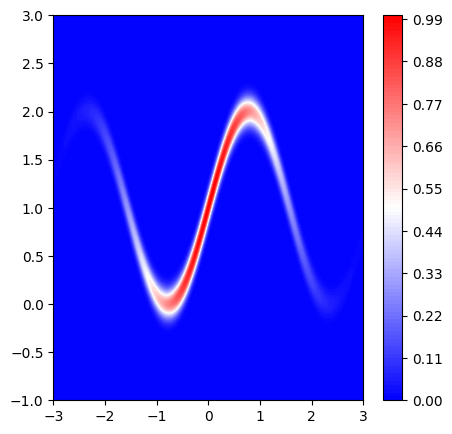

In [4]:
xmin, xmax = -3, 3
ymin, ymax = -1, 3
N_discr = 300
X, Y = np.meshgrid(np.linspace(xmin, xmax, N_discr), np.linspace(ymin, ymax, N_discr), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()
Z_flat = dist.batch(jnp.array([X_flat, Y_flat]).T)
Z = Z_flat.reshape(X.shape)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.show()

In [17]:
# create the GAIS samples
dais = DAIS(logtarget=dist)

n_samples = 10_000
n_iter = 50
alpha_damp = 0.1
ESS_threshold = 0.1
dim = 2
mu_init = jnp.zeros(dim)
cov_init = jnp.eye(dim)


# run the GAIS with the Gaussian family
key, key_ = jr.split(key)
output_gauss = dais.run(
                key = key_,
                n_samples=n_samples,
                n_iter=n_iter,
                mu_init=mu_init,
                cov_init=cov_init,
                ess_threshold=ESS_threshold,
                alpha_damp=alpha_damp,
                verbose=True)



[1/50] 	 eps: 0.55 	 ELBO: -121.01 	 ESS: 0.051
[2/50] 	 eps: 0.57 	 ELBO: -115.96 	 ESS: 0.053
[3/50] 	 eps: 0.62 	 ELBO: -104.91 	 ESS: 0.056
[4/50] 	 eps: 0.60 	 ELBO: -99.30 	 ESS: 0.053
[5/50] 	 eps: 0.67 	 ELBO: -92.62 	 ESS: 0.062
[6/50] 	 eps: 0.70 	 ELBO: -86.43 	 ESS: 0.064
[7/50] 	 eps: 0.74 	 ELBO: -79.31 	 ESS: 0.067
[8/50] 	 eps: 0.77 	 ELBO: -73.11 	 ESS: 0.072
[9/50] 	 eps: 0.81 	 ELBO: -69.22 	 ESS: 0.079
[10/50] 	 eps: 0.86 	 ELBO: -64.98 	 ESS: 0.084
[11/50] 	 eps: 0.90 	 ELBO: -61.16 	 ESS: 0.087
[12/50] 	 eps: 1.00 	 ELBO: -56.94 	 ESS: 0.101
[13/50] 	 eps: 1.00 	 ELBO: -54.13 	 ESS: 0.103
[14/50] 	 eps: 1.00 	 ELBO: -53.85 	 ESS: 0.104
[15/50] 	 eps: 1.00 	 ELBO: -49.97 	 ESS: 0.106
[16/50] 	 eps: 1.00 	 ELBO: -50.16 	 ESS: 0.113
[17/50] 	 eps: 0.93 	 ELBO: -48.79 	 ESS: 0.088
[18/50] 	 eps: 1.00 	 ELBO: -48.74 	 ESS: 0.115
[19/50] 	 eps: 1.00 	 ELBO: -47.10 	 ESS: 0.121
[20/50] 	 eps: 0.99 	 ELBO: -47.01 	 ESS: 0.098
[21/50] 	 eps: 0.96 	 ELBO: -46.42 	 ESS: 0.09

Text(0.5, 1.0, 'Epsilon trajectory')

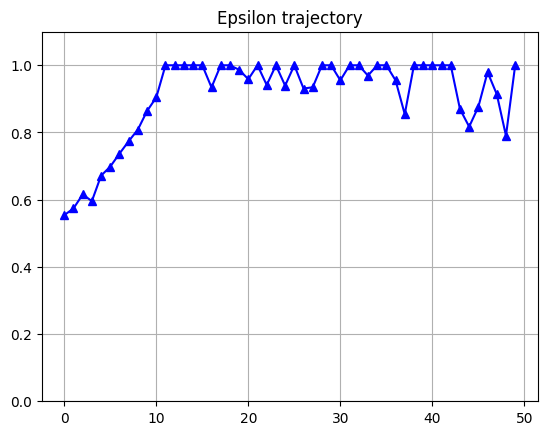

In [23]:
plt.plot(output_gauss["eps_traj"], "b-^")
plt.ylim(0,1.1)
plt.grid()

plt.title("Epsilon trajectory")


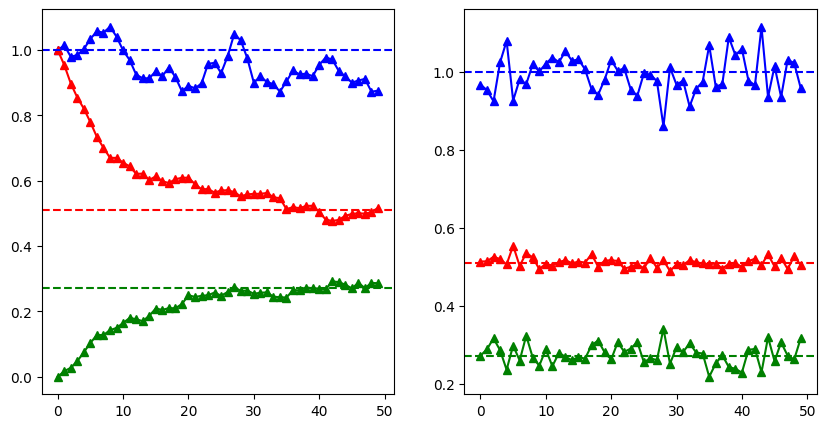

In [19]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(np.array(output_gauss["cov_traj"])[:, 0, 0], "b-^")
plt.plot(np.array(output_gauss["cov_traj"])[:, 0, 1], "g-^")
plt.plot(np.array(output_gauss["cov_traj"])[:, 1, 1], "r-^")

# horizontal line at the true value
plt.axhline(cov_accurate[0,0], color='b', linestyle='--')
plt.axhline(cov_accurate[0,1], color='g', linestyle='--')
plt.axhline(cov_accurate[1,1], color='r', linestyle='--')

plt.subplot(1,2,2)
plt.plot(np.array(output_gauss["cov_hat_traj"])[:, 0, 0], "b-^")
plt.plot(np.array(output_gauss["cov_hat_traj"])[:, 0, 1], "g-^")
plt.plot(np.array(output_gauss["cov_hat_traj"])[:, 1, 1], "r-^")

# horizontal line at the true value
plt.axhline(cov_accurate[0,0], color='b', linestyle='--')
plt.axhline(cov_accurate[0,1], color='g', linestyle='--')
plt.axhline(cov_accurate[1,1], color='r', linestyle='--')


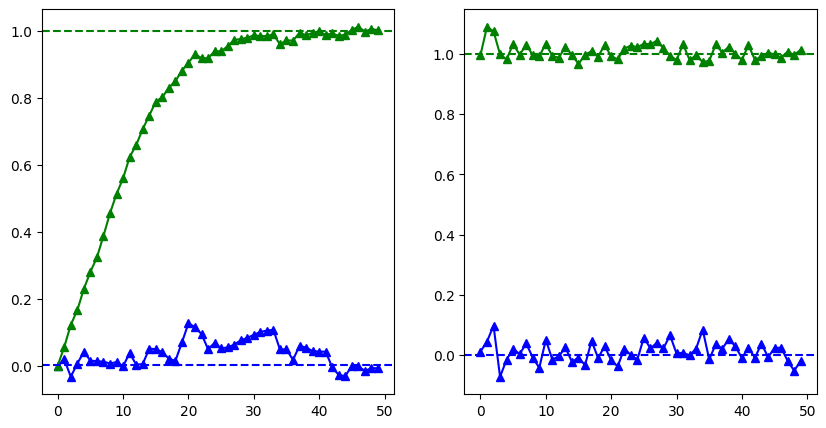

In [20]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(np.array(output_gauss["mu_traj"])[:, 0], "b-^")
plt.plot(np.array(output_gauss["mu_traj"])[:, 1], "g-^")

# horizontal line at the true value
plt.axhline(mu_accurate[0], color='b', linestyle='--')
plt.axhline(mu_accurate[1], color='g', linestyle='--')

plt.subplot(1,2,2)
plt.plot(np.array(output_gauss["mean_hat_traj"])[:, 0], "b-^")
plt.plot(np.array(output_gauss["mean_hat_traj"])[:, 1], "g-^")

# horizontal line at the true value
plt.axhline(mu_accurate[0], color='b', linestyle='--')
plt.axhline(mu_accurate[1], color='g', linestyle='--')

Text(0.5, 1.05, 'Generalized Adaptive Importance Sampling: Banana2D target')

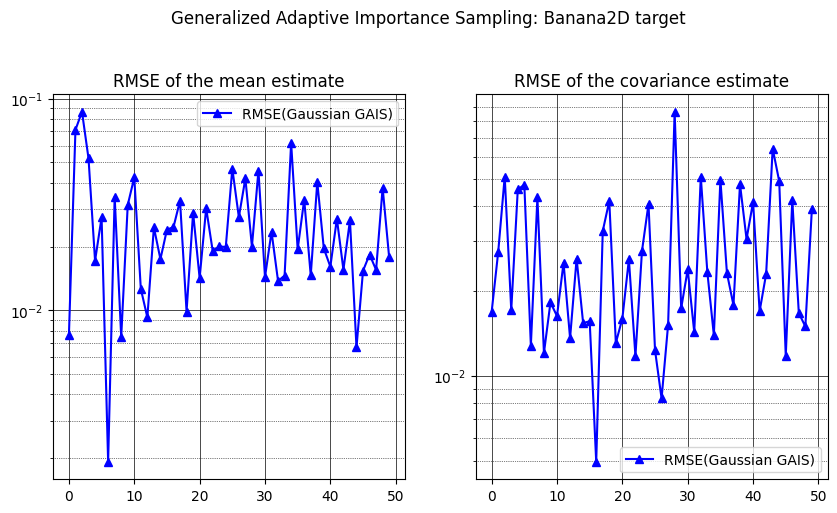

In [21]:
plt.figure(figsize=(10, 5))

# Mean estimate
plt.subplot(1, 2, 1)
mu_delta_gauss = np.array(output_gauss["mean_hat_traj"]) - mu_accurate[None, :]
mu_RMSE_gauss = np.sqrt(np.mean(mu_delta_gauss**2, axis=1))

#mu_delta_student = np.array(output_student["mean_hat_traj"]) - mu_accurate[None, :]
#mu_RMSE_student = np.sqrt(np.mean(mu_delta_student**2, axis=1))

plt.plot(mu_RMSE_gauss, "b-^", label="RMSE(Gaussian GAIS)")
#plt.plot(mu_RMSE_student, "r-^", label="RMSE(Student GAIS)")
plt.yscale('log')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.legend()

plt.title("RMSE of the mean estimate")

# covariance estimate
plt.subplot(1, 2, 2)
cov_delta_gauss = np.array(output_gauss["cov_hat_traj"]) - cov_accurate[None, :, :]
cov_RMSE_gauss = np.sqrt(np.mean(cov_delta_gauss**2, axis=(1, 2)))

#cov_delta_student = np.array(output_student["cov_hat_traj"]) - cov_accurate[None, :, :]
#cov_RMSE_student = np.sqrt(np.mean(cov_delta_student**2, axis=(1, 2)))

plt.plot(cov_RMSE_gauss, "b-^", label="RMSE(Gaussian GAIS)")
#plt.plot(cov_RMSE_student, "r-^", label="RMSE(Student GAIS)")
plt.yscale('log')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.legend()

plt.title("RMSE of the covariance estimate")

# add global title with a bit of space below the titles
plt.suptitle(r"Generalized Adaptive Importance Sampling: Banana2D target", y=1.05)
